In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rd81\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
epochs = 20
lr = 0.00001
n_labels = 9
manual_loss= False

In [3]:
label_to_id = {'flag_waving': 0, 'exaggeration,minimisation': 1, 'causal_oversimplification': 2, 'name_calling,labeling': 3, 'repetition': 4, 'doubt': 5, 'not_propaganda': 6, 'loaded_language': 7, 'appeal_to_fear_prejudice': 8}
id_to_label = {0: 'flag_waving', 1: 'exaggeration,minimisation', 2: 'causal_oversimplification', 3: 'name_calling,labeling', 4: 'repetition', 5: 'doubt', 6: 'not_propaganda', 7: 'loaded_language', 8: 'appeal_to_fear_prejudice'}


In [4]:
include_dev=False
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
batch_size_train = 16
batch_size_test = 16
batch_size_dev = 16

if include_dev:
    train_df, val_df, test_df = get_processed_data(dev=True)

    train_df= get_cols_for_bert(train_df, 'snip')
    val_df= get_cols_for_bert(val_df, 'snip')
    test_df= get_cols_for_bert(test_df, 'snip')

    train_input_embeddings_labelled = format_and_tokenise_from_df(train_df,task='snip', max_len=64)
    val_input_embeddings_labelled = format_and_tokenise_from_df(val_df,task='snip', max_len=64)
    test_input_embeddings_labelled = format_and_tokenise_from_df(test_df,task='snip', max_len=64)

    train_dataset = CustomPropagandaDataset(train_input_embeddings_labelled)
    test_dataset = CustomPropagandaDataset(test_input_embeddings_labelled)
    val_dataset = CustomPropagandaDataset(val_input_embeddings_labelled)



    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_dev, shuffle=True)


else:
    train_df, val_df = get_processed_data(dev=False)

    train_df= get_cols_for_bert(train_df, 'snip')
    val_df= get_cols_for_bert(val_df, 'snip')

    train_input_embeddings_labelled = format_and_tokenise_from_df(train_df,task='snip', max_len=64)
    val_input_embeddings_labelled = format_and_tokenise_from_df(val_df,task='snip', max_len=64)

    train_dataset = CustomPropagandaDataset(train_input_embeddings_labelled)
    val_dataset = CustomPropagandaDataset(val_input_embeddings_labelled)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_dev, shuffle=True)




In [5]:
def plot_training(train_losses, train_accuracy, val_losses, val_accuracy):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.xticks(epochs)  # Set x-axis ticks to only be at each epoch

    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Set x-axis ticks to only be at each epoch

    plt.ylim(0, 1)  # This sets the y-axis to be between 0 and 1

    plt.legend()

    plt.tight_layout()
    plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAIN: Epoch [1/20] Loss: 1.7140112832188605 Acc: 0.474609375


VAL: Epoch [1/20] Loss: 1.51250878572464 Acc: 0.5171875


TRAIN: Epoch [2/20] Loss: 1.519931048899889 Acc: 0.50234375


VAL: Epoch [2/20] Loss: 1.4253534987568854 Acc: 0.525


TRAIN: Epoch [3/20] Loss: 1.415590974316001 Acc: 0.52265625


VAL: Epoch [3/20] Loss: 1.3859452098608016 Acc: 0.540625


TRAIN: Epoch [4/20] Loss: 1.2850731659680605 Acc: 0.56015625


VAL: Epoch [4/20] Loss: 1.3975176617503167 Acc: 0.5359375


TRAIN: Epoch [5/20] Loss: 1.1445394838228822 Acc: 0.615625


VAL: Epoch [5/20] Loss: 1.408643615245819 Acc: 0.5453125


TRAIN: Epoch [6/20] Loss: 1.010892061330378 Acc: 0.64921875


VAL: Epoch [6/20] Loss: 1.4089184924960136 Acc: 0.5078125


TRAIN: Epoch [7/20] Loss: 0.8732948126271367 Acc: 0.709765625


VAL: Epoch [7/20] Loss: 1.4092733949422835 Acc: 0.5390625


TRAIN: Epoch [8/20] Loss: 0.7736055843532086 Acc: 0.742578125


VAL: Epoch [8/20] Loss: 1.5074885919690133 Acc: 0.5703125


TRAIN: Epoch [9/20] Loss: 0.6872950118035078 Acc: 0.7703125


VAL: Epoch [9/20] Loss: 1.5437636867165565 Acc: 0.5609375


TRAIN: Epoch [10/20] Loss: 0.5545179074630141 Acc: 0.82578125


VAL: Epoch [10/20] Loss: 1.5496003866195678 Acc: 0.546875


TRAIN: Epoch [11/20] Loss: 0.4817517320625484 Acc: 0.86015625


VAL: Epoch [11/20] Loss: 1.602755604684353 Acc: 0.575


TRAIN: Epoch [12/20] Loss: 0.40421776408329607 Acc: 0.8796875


VAL: Epoch [12/20] Loss: 1.6480315431952477 Acc: 0.546875


TRAIN: Epoch [13/20] Loss: 0.3594974994659424 Acc: 0.905859375


VAL: Epoch [13/20] Loss: 1.7216187939047813 Acc: 0.5640625


TRAIN: Epoch [14/20] Loss: 0.27774802343919874 Acc: 0.9296875


VAL: Epoch [14/20] Loss: 1.7760648012161255 Acc: 0.575


TRAIN: Epoch [15/20] Loss: 0.2085819581290707 Acc: 0.949609375


VAL: Epoch [15/20] Loss: 1.7633993595838546 Acc: 0.5859375


TRAIN: Epoch [16/20] Loss: 0.19045813996344804 Acc: 0.952734375


VAL: Epoch [16/20] Loss: 1.8887063920497895 Acc: 0.5671875


TRAIN: Epoch [17/20] Loss: 0.14984517993871121 Acc: 0.963671875


VAL: Epoch [17/20] Loss: 1.955192206799984 Acc: 0.5578125


TRAIN: Epoch [18/20] Loss: 0.13414206879679114 Acc: 0.9671875


VAL: Epoch [18/20] Loss: 1.96391304731369 Acc: 0.56875


TRAIN: Epoch [19/20] Loss: 0.09584961064392701 Acc: 0.9796875


VAL: Epoch [19/20] Loss: 2.0429761692881585 Acc: 0.5765625


TRAIN: Epoch [20/20] Loss: 0.08870038740569726 Acc: 0.9796875


VAL: Epoch [20/20] Loss: 2.080919674038887 Acc: 0.5453125


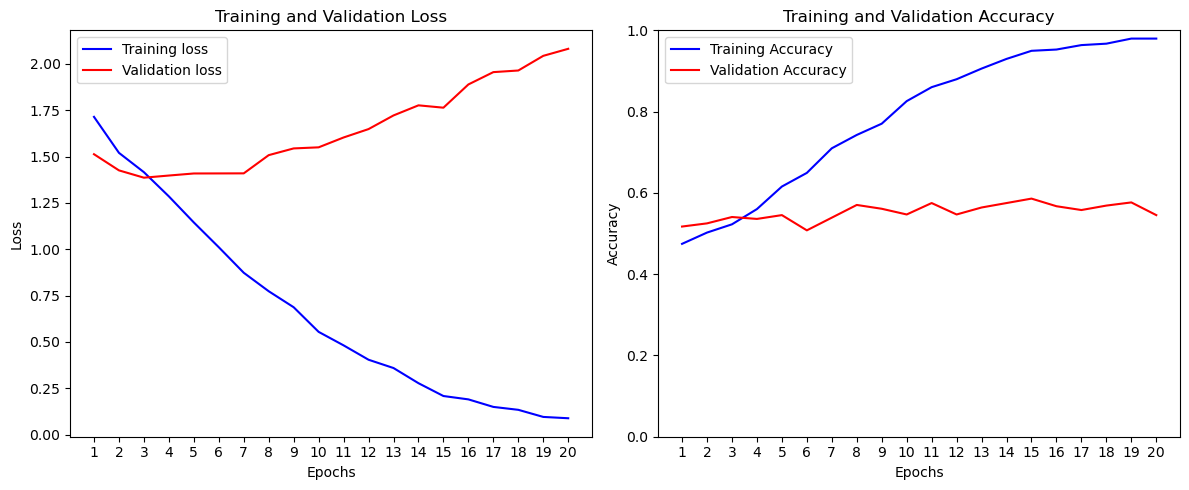

In [6]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        if manual_loss:
            loss = criterion(outputs.logits, batch['labels'])
        else:
            loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted_labels = torch.max(outputs.logits, dim=1)
        train_total += batch['labels'].size(0)
        train_correct += (predicted_labels == batch['labels']).sum().item()
        train_running_losses.append(loss.item())
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch+1}/{epochs}] Loss: {sum(train_running_losses)/len(train_running_losses)} Acc: {train_correct/train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            _, predicted_labels = torch.max(outputs.logits, dim=1)
            val_total += batch['labels'].size(0)
            val_correct += (predicted_labels == batch['labels']).sum().item()
            val_running_losses.append(loss.item())
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch+1}/{epochs}] Loss: {sum(val_running_losses)/len(val_running_losses)} Acc: {val_correct/val_total}')
    
    if include_dev:
        print('TESTING...')
        test_losses = []
        test_accuracy = []
        
        model.eval()
        with torch.no_grad():
            test_running_losses = []
            test_total = 0
            test_correct = 0
            
            for batch in test_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                
                _, predicted_labels = torch.max(outputs.logits, dim=1)
                test_total += batch['labels'].size(0)
                test_correct += (predicted_labels == batch['labels']).sum().item()
                test_running_losses.append(loss.item())
            
            test_losses.append(sum(test_running_losses) / len(test_running_losses))
            test_accuracy.append(test_correct / test_total)
            print(f'TEST: Epoch [{epoch+1}/{epochs}] Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')

plot_training(train_losses, train_accuracy, val_losses, val_accuracy)